# Data Analysis and Performance Management

<img style="float: right;" src="https://wu.kozminski.edu.pl/WU/Content/images/logo.png" width="150">

## Group Project

*Serdar Goler, Kacper Krzyskow, Teymur Mahmudov, Piotr Sokol - January 07, 2021*

`CREDIT` Hasan, B., Hoodbhoy, Z., Noman, M., Shafique, A., Nasim, A. and Chowdhury, D. (2019). Use of machine learning algorithms for prediction of fetal risk using cardiotocographic data. International Journal of Applied and Basic Medical Research, [online] 9(4), p.226. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6822315/ [Accessed 30 Dec. 2021].

`DATA` Uci.edu. (2021). UCI Machine Learning Repository: Cardiotocography Data Set. [online] Available at: https://archive.ics.uci.edu/ml/datasets/Cardiotocography [Accessed 30 Dec. 2020].

***
`WARNING` Execution of this script takes over **7 minutes**!
***

# Installation and Data Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize, StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from pprint import pprint
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from itertools import product
import xgboost as xgb
from xgboost import XGBClassifier
#conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
#pip install packyou
from packyou.github.DTrimarchi10.confusion_matrix.cf_matrix import make_confusion_matrix
#conda install -c conda-forge shap
#import shap

In [2]:
dataset = pd.read_excel("CTG.xlsx")

# Exploratory Data Analysis

In [3]:
dataset.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,240,357,0,0,0,0,0,0,0,120,...,62,126,2,0,120,137,121,73,1,2
1,5,632,4,0,4,2,0,0,0,132,...,68,198,6,1,141,136,140,12,0,1
2,177,779,2,0,5,2,0,0,0,133,...,68,198,5,1,141,135,138,13,0,1
3,411,1192,2,0,6,2,0,0,0,134,...,53,170,11,0,137,134,137,13,1,1
4,533,1147,4,0,5,0,0,0,0,132,...,53,170,9,0,137,136,138,11,1,1


In [4]:
dataset.iloc[:,:11].describe()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,AC.1
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.0,2126.000000,2126.000000
mean,878.439793,1702.877234,2.722484,7.241298,3.659925,1.570085,0.003293,0.126058,0.0,133.303857,0.003170
std,894.084748,930.919143,3.560850,37.125309,2.847094,2.499229,0.057300,0.464361,0.0,9.840844,0.003860
min,0.000000,287.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,106.000000,0.000000
25%,55.000000,1009.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,126.000000,0.000000
50%,538.000000,1241.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.0,133.000000,0.001630
75%,1521.000000,2434.750000,4.000000,2.000000,5.000000,3.000000,0.000000,0.000000,0.0,140.000000,0.005631
max,3296.000000,3599.000000,26.000000,564.000000,23.000000,16.000000,1.000000,4.000000,0.0,160.000000,0.019284


In [5]:
dataset.iloc[:,11:21].describe()

,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,MLTV,Width
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000
mean,0.009474,0.004357,0.001885,0.000004,0.000157,46.990122,1.332785,9.84666,8.187629,70.445908
std,0.046670,0.002940,0.002962,0.000063,0.000580,17.192814,0.883241,18.39688,5.628247,38.955693
min,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000
25%,0.000000,0.001876,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000
50%,0.000000,0.004482,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000
75%,0.002512,0.006525,0.003264,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000
max,0.480634,0.014925,0.015385,0.001353,0.005348,87.000000,7.000000,91.00000,50.700000,180.000000


In [6]:
dataset.iloc[:,21:31].describe()

,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [7]:
dataset.shape

(2126, 31)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2126 non-null   int64  
 1   e         2126 non-null   int64  
 2   AC        2126 non-null   int64  
 3   FM        2126 non-null   int64  
 4   UC        2126 non-null   int64  
 5   DL        2126 non-null   int64  
 6   DS        2126 non-null   int64  
 7   DP        2126 non-null   int64  
 8   DR        2126 non-null   int64  
 9   LB        2126 non-null   int64  
 10  AC.1      2126 non-null   float64
 11  FM.1      2126 non-null   float64
 12  UC.1      2126 non-null   float64
 13  DL.1      2126 non-null   float64
 14  DS.1      2126 non-null   float64
 15  DP.1      2126 non-null   float64
 16  ASTV      2126 non-null   int64  
 17  MSTV      2126 non-null   float64
 18  ALTV      2126 non-null   int64  
 19  MLTV      2126 non-null   float64
 20  Width     2126 non-null   int6

In [9]:
# check for missing values in any column
dataset.isnull().sum()

b           0
e           0
AC          0
FM          0
UC          0
DL          0
DS          0
DP          0
DR          0
LB          0
AC.1        0
FM.1        0
UC.1        0
DL.1        0
DS.1        0
DP.1        0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
NSP         0
dtype: int64

In [10]:
#sns.heatmap(dataset.isnull())

In [11]:
dataset.NSP.value_counts(normalize=True)

1    0.778457
2    0.138758
3    0.082785
Name: NSP, dtype: float64

In [12]:
cor_mat= dataset.drop(columns='NSP').corr()
cor_mat

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
b,1.000000,0.944912,-0.038359,-0.133849,0.225595,0.091783,0.063977,0.091688,NaN,-0.020400,...,-0.068933,0.048558,-0.069657,-0.070227,0.023108,-0.034576,-0.082295,-0.071608,0.054851,-0.033067
e,0.944912,1.000000,0.071572,-0.119249,0.386856,0.163257,0.068221,0.111917,NaN,-0.013979,...,-0.027059,0.022379,-0.021877,-0.028026,0.017117,-0.016790,-0.077542,-0.052254,0.052357,-0.025311
AC,-0.038359,0.071572,1.000000,0.053956,0.212100,-0.011350,-0.039341,-0.110317,NaN,-0.077967,...,0.291516,-0.157447,0.373493,0.191475,-0.011430,0.221693,0.236811,0.250729,0.111981,0.032235
FM,-0.133849,-0.119249,0.053956,1.000000,-0.036626,0.076283,-0.010328,0.205337,NaN,-0.033305,...,0.171448,-0.158422,0.111228,0.183904,-0.014632,-0.037492,-0.085718,-0.056281,0.177793,-0.000069
UC,0.225595,0.386856,0.212100,-0.036626,1.000000,0.339484,0.018405,0.152395,NaN,-0.127722,...,0.152990,-0.112597,0.146645,0.095512,0.022701,-0.077695,-0.169739,-0.111041,0.184188,-0.060995
DL,0.091783,0.163257,-0.011350,0.076283,0.339484,1.000000,0.121617,0.294068,NaN,-0.155908,...,0.520656,-0.539125,0.242187,0.393860,0.208487,-0.315463,-0.509446,-0.353878,0.515130,-0.000687
DS,0.063977,0.068221,-0.039341,-0.010328,0.018405,0.121617,1.000000,0.019766,NaN,-0.053518,...,0.044880,-0.071974,-0.021135,0.007024,0.043441,-0.215161,-0.158673,-0.160451,0.136421,-0.070483
DP,0.091688,0.111917,-0.110317,0.205337,0.152395,0.294068,0.019766,1.000000,NaN,-0.117133,...,0.282790,-0.291175,0.134254,0.240768,0.046320,-0.413445,-0.511503,-0.445473,0.487212,-0.205469
DR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LB,-0.020400,-0.013979,-0.077967,-0.033305,-0.127722,-0.155908,-0.053518,-0.117133,NaN,1.000000,...,-0.147679,0.361619,0.275110,-0.113933,-0.004745,0.708993,0.723121,0.789246,-0.133938,0.293503


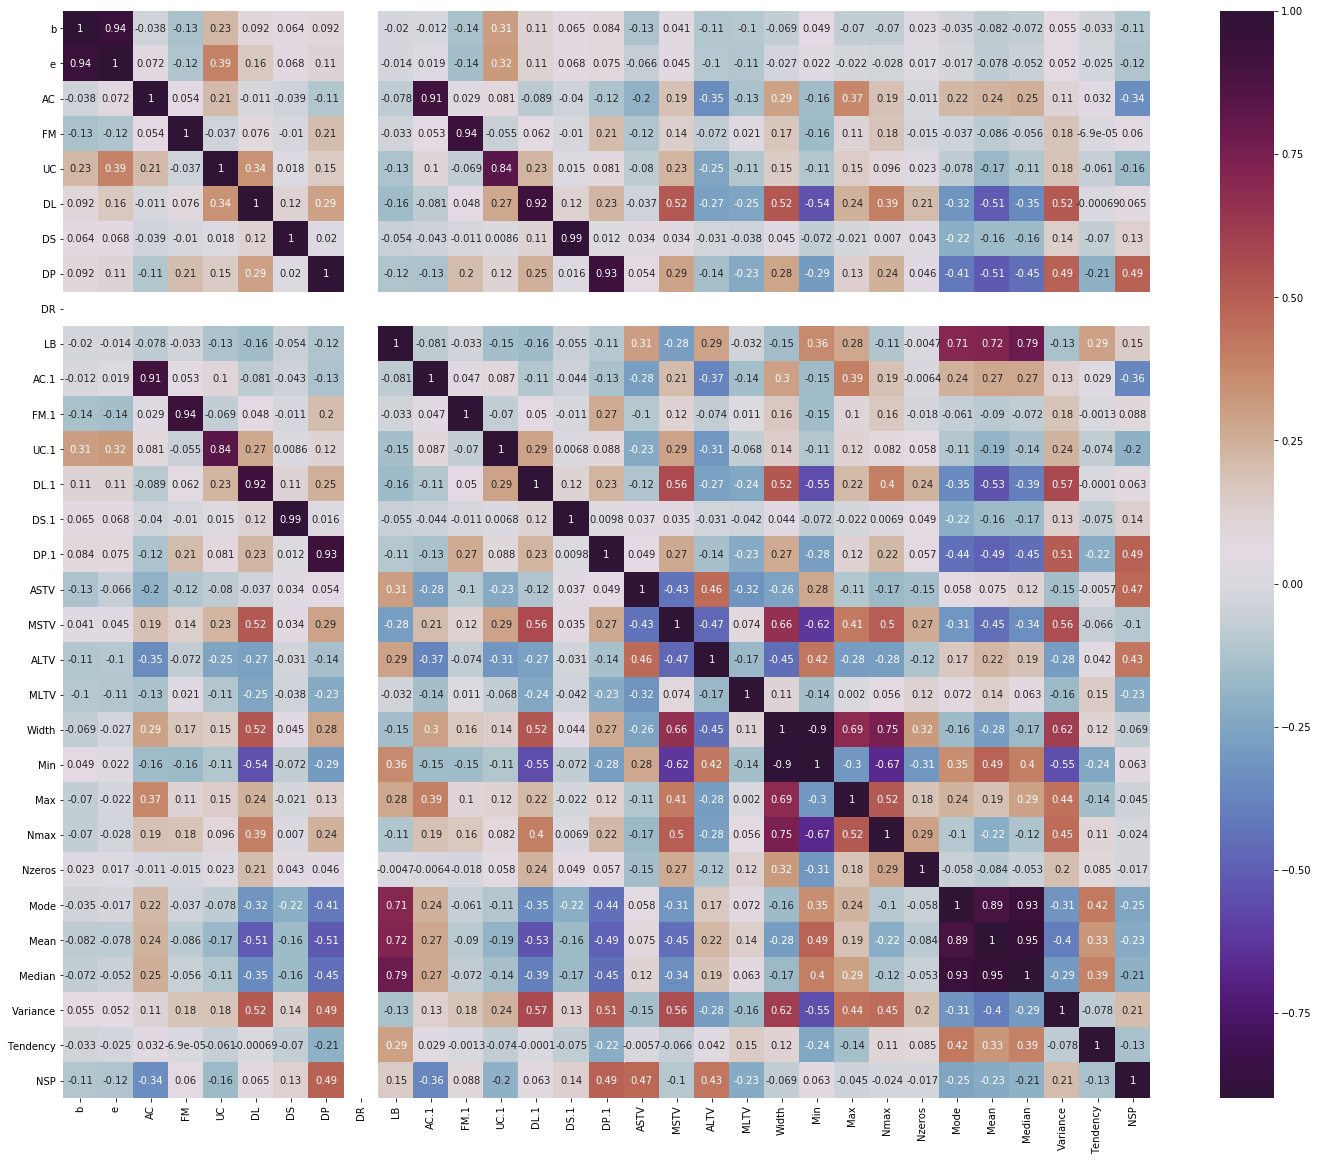

In [13]:
plt.figure(figsize=(25,20))
sns.heatmap(dataset.corr(),square=True,annot=True,cmap= 'twilight_shifted')

# Data Preprocessing

### Train/Test Split

In [14]:
X = dataset.iloc[:, dataset.columns != 'NSP']           
X.drop(['b','AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR'], inplace=True, axis=1) # dropping correlated features
y = dataset.iloc[:, -1]

C:\Users\serda\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


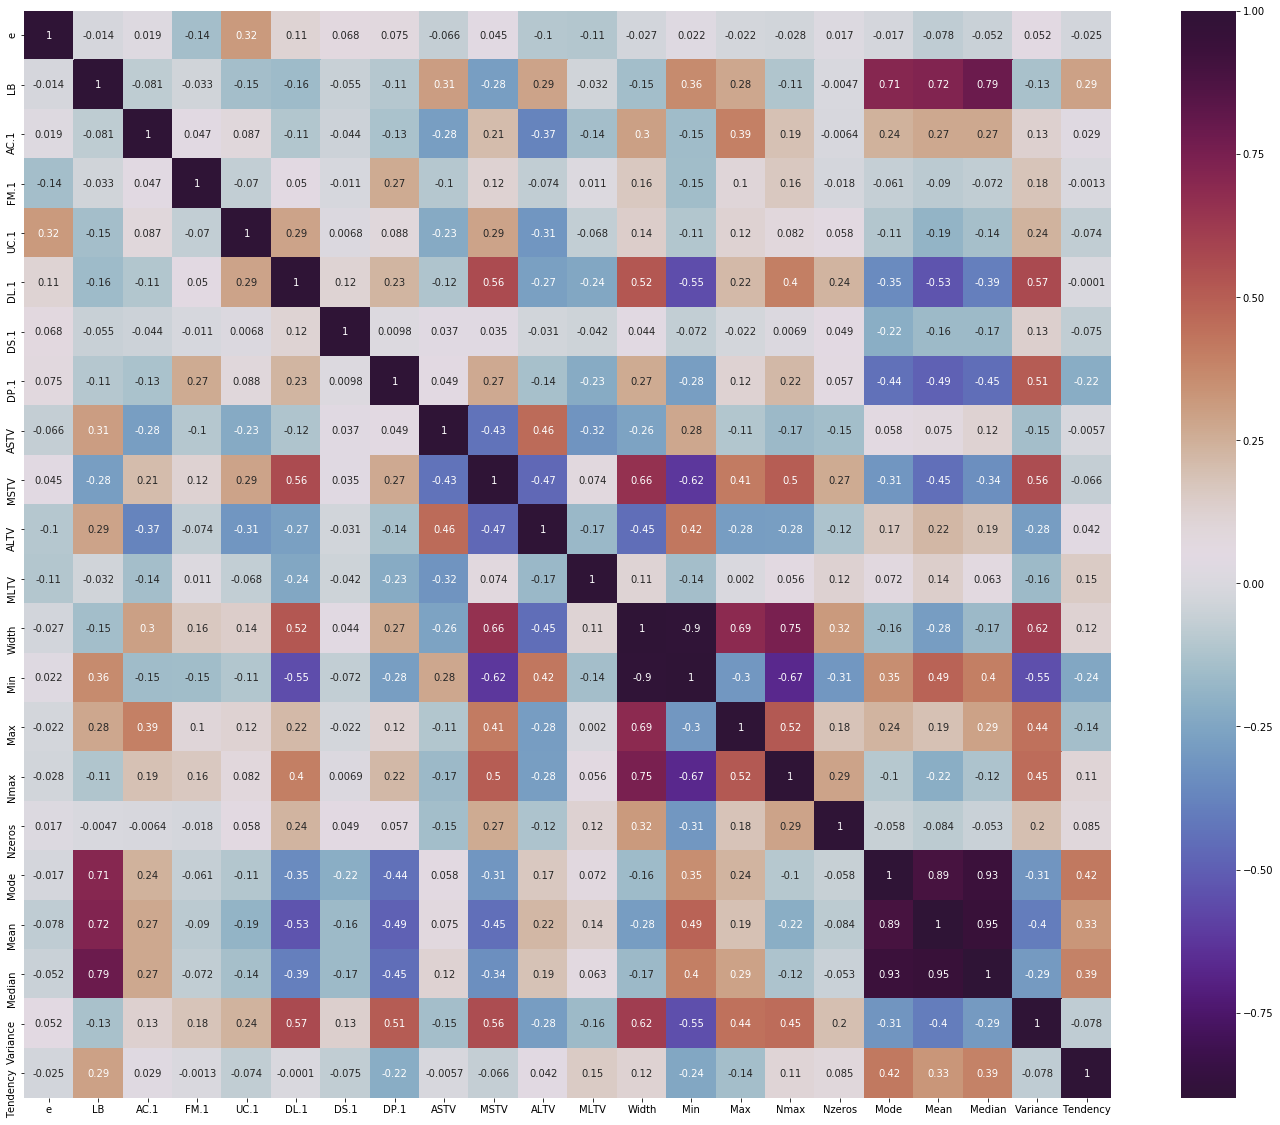

In [15]:
plt.figure(figsize=(25,20))
sns.heatmap(X.corr(),square=True,annot=True,cmap= 'twilight_shifted')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

### ROC Curve Function

There is no proper way in order to draw ROC Curve and calculate AUC score for multiclass data. Therefore, we found out a function to do that.

In [17]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# Modelling

## Logistic Regression

In [18]:
%%time
lr = LogisticRegression()
lr_model= lr.fit(X_train, y_train)
y_train_pred= lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

Wall time: 288 ms


C:\Users\serda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


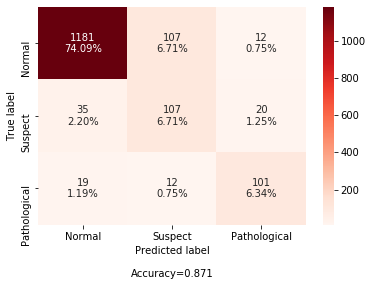

In [19]:
lr_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(lr_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

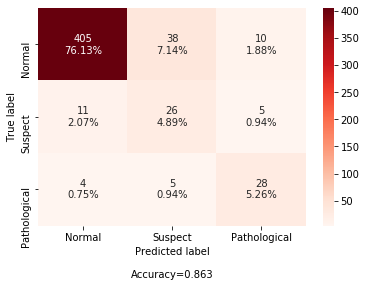

In [20]:
lr_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(lr_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [21]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.894     0.964     0.928       420
           2      0.619     0.377     0.468        69
           3      0.757     0.651     0.700        43

    accuracy                          0.863       532
   macro avg      0.757     0.664     0.699       532
weighted avg      0.847     0.863     0.850       532



**Macro avg =** Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**Weighted avg =** Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**`WARNING`** Since our dataset is about health issue and the most important goal is correctly predict non-normal fetals then higher recall is better for each class because the recall rate is penalized whenever a false negative is predicted. Furthermore the dataset is imbalanced, so the weighted avg recall and weighted avg f1-score are the most important metrics for whole model. 

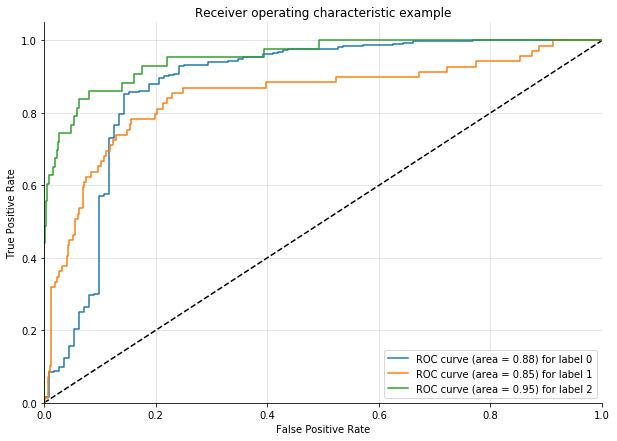

In [22]:
plot_multiclass_roc(lr, X_test, y_test, n_classes=3, figsize=(10, 7))

Since the ROC function based on the predict_proba ROC-AUC does not consistent with the results of classification report.

`COMMENT` We have imbalanced dataset and getting high overall accuracy and low recall scores for suspect and pathological cases, let's see when imply SMOTE(Over-sampling), NearMiss(Under-sampling) techniques to balance the dataset, how the model will change.

### Handling Imbalanced Dataset 

#### 1- SMOTE (Synthetic Minority Over-sampling Technique)

In [23]:
y_train.value_counts()

1    1235
2     226
3     133
Name: NSP, dtype: int64

In [24]:
smt = SMOTE()
X_train_os, y_train_os = smt.fit_sample(X_train, y_train)

In [25]:
y_train_os.value_counts()

3    1235
1    1235
2    1235
Name: NSP, dtype: int64

In [26]:
%%time
lr = LogisticRegression()
lr_model = lr.fit(X_train_os, y_train_os)
y_test_pred = lr_model.predict(X_test)

Wall time: 461 ms


C:\Users\serda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


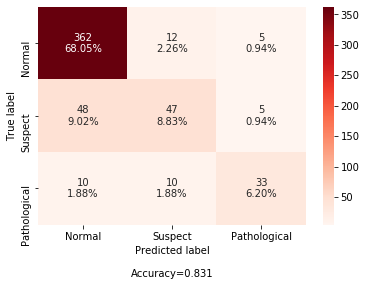

In [27]:
os_lr_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(os_lr_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [28]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.955     0.862     0.906       420
           2      0.470     0.681     0.556        69
           3      0.623     0.767     0.688        43

    accuracy                          0.831       532
   macro avg      0.683     0.770     0.717       532
weighted avg      0.865     0.831     0.843       532



#### 2- NearMiss (Under-sampling)

In [29]:
nr = NearMiss()
X_train_us, y_train_us = nr.fit_sample(X_train, y_train)

In [30]:
y_train_us.value_counts()

3    133
2    133
1    133
Name: NSP, dtype: int64

In [31]:
%%time
lr = LogisticRegression()
lr_model = lr.fit(X_train_us, y_train_us)
y_test_pred = lr_model.predict(X_test)

Wall time: 94.8 ms


C:\Users\serda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


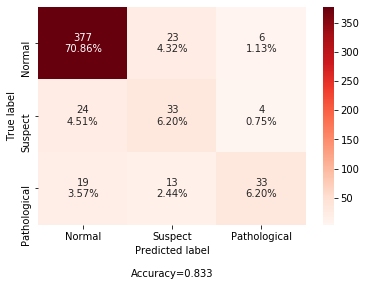

In [32]:
us_lr_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(us_lr_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [33]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.929     0.898     0.913       420
           2      0.541     0.478     0.508        69
           3      0.508     0.767     0.611        43

    accuracy                          0.833       532
   macro avg      0.659     0.714     0.677       532
weighted avg      0.844     0.833     0.836       532



**RESULTS FOR LOGISTIC REGRESSION:** This model is better than the first model because it classifies better. But since in this case, SMOTE is giving us a better accuracy and recall, we can go ahead and use that model.

### Multicollinearity

In [34]:
# For each X, calculate VIF and save in dataframe
x_temp = sm.add_constant(X_train)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
print(vif.round(1))

    VIF Factor  features
0        264.1     const
1          1.2         e
2          7.0        LB
3          2.9      AC.1
4          1.2      FM.1
5          1.4      UC.1
6          3.6      DL.1
7          1.2      DS.1
8          2.9      DP.1
9          2.0      ASTV
10         3.1      MSTV
11         1.9      ALTV
12         2.1      MLTV
13         inf     Width
14         inf       Min
15         inf       Max
16         2.3      Nmax
17         1.2    Nzeros
18         9.4      Mode
19        20.8      Mean
20        26.7    Median
21         2.6  Variance
22         2.9  Tendency


C:\Users\serda\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Multicollinearity is a problem for Logit model. It should not be more than 5 if you want to use Logit model.

## kNN

In [35]:
%%time
knn= KNeighborsClassifier()
knn_model = knn.fit(X_train_os, y_train_os)
y_train_pred= knn_model.predict(X_train_os)
y_test_pred = knn_model.predict(X_test)

Wall time: 623 ms


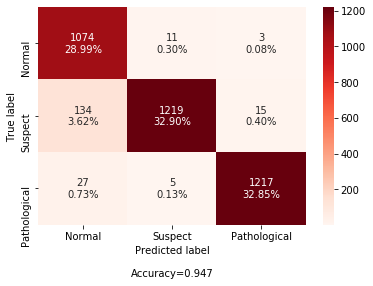

In [36]:
knn_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(knn_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

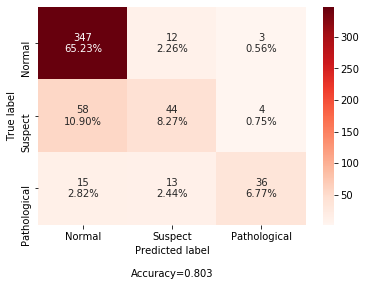

In [37]:
knn_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(knn_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [38]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.959     0.826     0.887       420
           2      0.415     0.638     0.503        69
           3      0.562     0.837     0.673        43

    accuracy                          0.803       532
   macro avg      0.645     0.767     0.688       532
weighted avg      0.856     0.803     0.820       532



Despite kNN is working great on over-sampled training data, it is overfitting on test data. 

### Feature Scaling

Features in the dataset are big in scale compared to others then in algorithms where Euclidean distance is measured such as kNN this big scaled feature becomes dominating and needs to be normalized or standardized.

**`Source:`** GeeksforGeeks. (2018). Python | How and where to apply Feature Scaling? - GeeksforGeeks. [online] Available at: https://www.geeksforgeeks.org/python-how-and-where-to-apply-feature-scaling/ [Accessed 4 Jan. 2021].

### Normalization

In [39]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train_os)

# transform training data
X_train_norm = norm.transform(X_train_os)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [40]:
%%time
knn= KNeighborsClassifier()
knn_model2 = knn.fit(X_train_norm, y_train_os)
y_train_pred= knn_model2.predict(X_train_norm)
y_test_pred = knn_model2.predict(X_test_norm)

Wall time: 936 ms


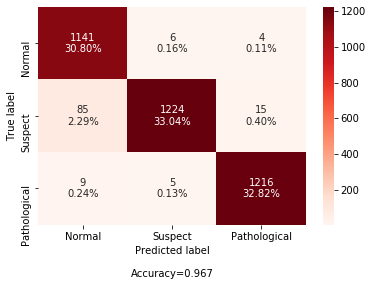

In [41]:
norm_knn_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(norm_knn_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [42]:
print(classification_report(y_train_os, y_train_pred, digits=3))

              precision    recall  f1-score   support

           1      0.991     0.924     0.956      1235
           2      0.924     0.991     0.957      1235
           3      0.989     0.985     0.987      1235

    accuracy                          0.967      3705
   macro avg      0.968     0.967     0.967      3705
weighted avg      0.968     0.967     0.967      3705



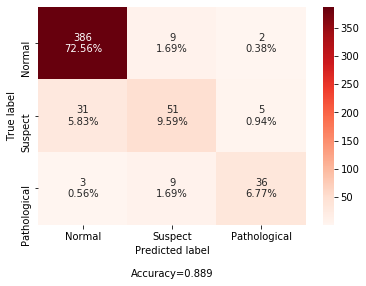

In [43]:
norm_knn_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(norm_knn_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [44]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.972     0.919     0.945       420
           2      0.586     0.739     0.654        69
           3      0.750     0.837     0.791        43

    accuracy                          0.889       532
   macro avg      0.769     0.832     0.797       532
weighted avg      0.904     0.889     0.895       532



### Standardization

In [45]:
# copy of datasets
X_train_stand = X_train_os.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = dataset.drop(columns=['b','DS', 'NSP', 'AC', 'FM', 'UC', 'DL', 'DP', 'DR'])

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [46]:
%%time
knn= KNeighborsClassifier()
knn_model3 = knn.fit(X_train_stand, y_train_os)
y_train_pred = knn_model3.predict(X_train_stand)
y_test_pred = knn_model3.predict(X_test_stand)

Wall time: 1.01 s


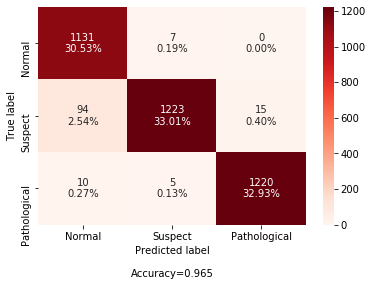

In [47]:
stand_knn_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(stand_knn_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

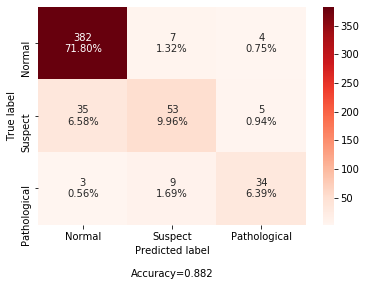

In [48]:
stand_knn_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(stand_knn_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [49]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.972     0.910     0.940       420
           2      0.570     0.768     0.654        69
           3      0.739     0.791     0.764        43

    accuracy                          0.882       532
   macro avg      0.760     0.823     0.786       532
weighted avg      0.901     0.882     0.889       532



**RESULTS FOR FEATURE SCALING:** Standardization gives the best performance with kNN on SMOTE data.

### Tuning for KNN

In [50]:
%%time
#Parameter tuning with GridSearchCV 

#######################
### K-Nearest Neighbors
#######################

estimator = KNeighborsClassifier(algorithm='auto')
parameters = {
    'n_neighbors': (1,5,10,15,20,25),
    'leaf_size': (20,30,40,50,60),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')}
                   
# with GridSearch
grid_search_kNN = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10
)

knn_model4 = grid_search_kNN.fit(X_train_stand, y_train_os)
y_train_pred = knn_model4.predict(X_train_stand)
y_test_pred = knn_model4.predict(X_test_stand)

Wall time: 43.1 s


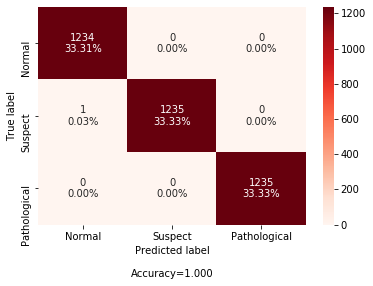

In [51]:
tuned_stand_knn_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tuned_stand_knn_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

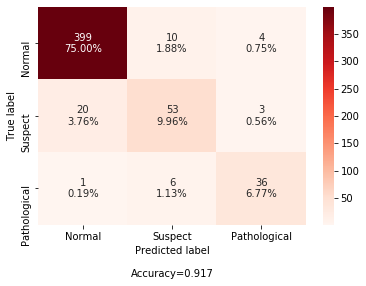

In [52]:
tuned_stand_knn_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tuned_stand_knn_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [53]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.966     0.950     0.958       420
           2      0.697     0.768     0.731        69
           3      0.837     0.837     0.837        43

    accuracy                          0.917       532
   macro avg      0.834     0.852     0.842       532
weighted avg      0.921     0.917     0.919       532



**RESULTS FOR kNN:** kNN algorithm performs better on standardized or normalized data because it works by measuring the distance of a certain number of neighbors, while kNN increases its accuracy on larger datasets, as the number of samples increases when data is SMOTED. After tuning parameters to find the best parameters, over-fitting is seen on test data, although it performs close to perfect on train data, although performance is improved for normal cases and a better model is achieved overall.

## LDA

In [54]:
%%time
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train, y_train)
y_train_pred = lda_model.predict(X_train)
y_test_pred = lda_model.predict(X_test)

Wall time: 48 ms


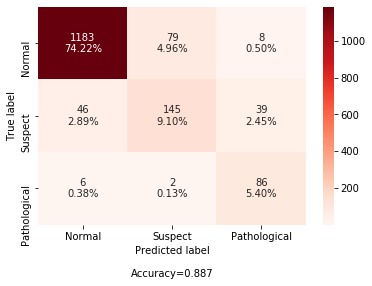

In [55]:
lda_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(lda_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

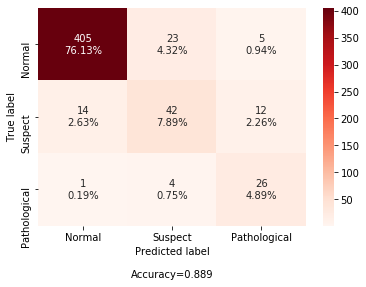

In [56]:
lda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(lda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [57]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.935     0.964     0.950       420
           2      0.618     0.609     0.613        69
           3      0.839     0.605     0.703        43

    accuracy                          0.889       532
   macro avg      0.797     0.726     0.755       532
weighted avg      0.886     0.889     0.886       532



#### Over-sampling

In [58]:
%%time
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train_os, y_train_os)
y_test_pred = lda_model.predict(X_test)

Wall time: 64 ms


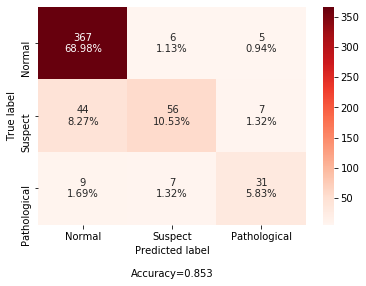

In [59]:
os_lda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(os_lda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [60]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.971     0.874     0.920       420
           2      0.523     0.812     0.636        69
           3      0.660     0.721     0.689        43

    accuracy                          0.853       532
   macro avg      0.718     0.802     0.748       532
weighted avg      0.888     0.853     0.864       532



#### Under-sampling

In [61]:
%%time
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train_us, y_train_us)
y_test_pred = lda_model.predict(X_test)

Wall time: 40 ms


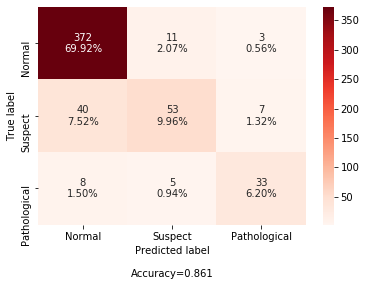

In [62]:
us_lda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(us_lda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [63]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.964     0.886     0.923       420
           2      0.530     0.768     0.627        69
           3      0.717     0.767     0.742        43

    accuracy                          0.861       532
   macro avg      0.737     0.807     0.764       532
weighted avg      0.888     0.861     0.870       532



**RESULTS FOR SAMPLING ON LDA:** If the goal is predict more suspect and pathological cases correctly then under-sampling gives the best performance in LDA. Otherwise, data sampling is not a good idea.

***WARNING*** Since the data has varying scales and the LDA makes assumptions about the data having a Gaussian distribution then Standardization is useful. Because it assumes that the data has a Gaussian (bell curve) distribution. This does not strictly have to be true, but the technique is more effective if the attribute distribution is Gaussian.

**`Source:`** Towards AI Team (2019). How, When, and Why Should You Normalize / Standardize / Rescale Your... [online] Towards AI — The Best of Tech, Science, and Engineering. Available at: https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff [Accessed 4 Jan. 2021].

#### LDA on Standardized and Under-sampled Data

In [64]:
# STANDARDIZATION OF UNDER-SAMPLED DATA
# copy of datasets
X_train_stand_us = X_train_us.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = dataset.drop(columns=['b','DS', 'NSP', 'AC', 'FM', 'UC', 'DL', 'DP', 'DR'])

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand_us[[i]])
    
    # transform the training data column
    X_train_stand_us[i] = scale.transform(X_train_stand_us[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [65]:
%%time
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train_stand_us, y_train_us)
y_train_pred = lda_model.predict(X_train_stand_us)
y_test_pred = lda_model.predict(X_test_stand)

Wall time: 24 ms


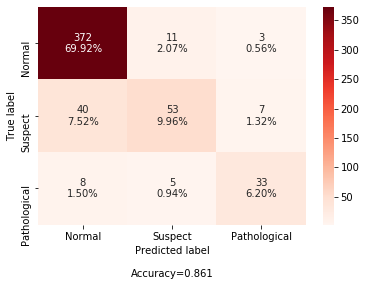

In [66]:
stand_us_lda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(stand_us_lda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [67]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.964     0.886     0.923       420
           2      0.530     0.768     0.627        69
           3      0.717     0.767     0.742        43

    accuracy                          0.861       532
   macro avg      0.737     0.807     0.764       532
weighted avg      0.888     0.861     0.870       532



**COMMENT ABOUT STANDARDIZATION OF OVER-SAMPLED DATA:** The result are the same as unscaled data.

### Tuning for LDA

#### LDA Tuning with LSQR-EIGEN

In [68]:
%%time
#Parameter tuning with GridSearchCV 

#######################
### LDA  - lsqr - eigen
#######################

estimator = LinearDiscriminantAnalysis(shrinkage='auto')
parameters = {
    'solver': ('lsqr', 'eigen'),  #note svd does not run with shrinkage and models using it will be tuned separately
    'n_components': (1,5,10),
                   }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# with GridSearch
grid_search_lda = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv
)

lda_model2 = grid_search_lda.fit(X_train_stand_us, y_train_us)
y_train_pred = lda_model2.predict(X_train_stand_us)
y_test_pred = lda_model2.predict(X_test_stand)

Wall time: 1.01 s


C:\Users\serda\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.80711538 0.80711538        nan        nan        nan        nan]
  category=UserWarning


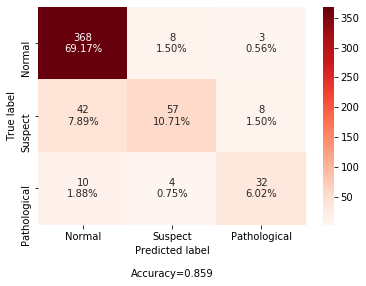

In [69]:
tune_stand_us_lda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_stand_us_lda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [70]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.971     0.876     0.921       420
           2      0.533     0.826     0.648        69
           3      0.696     0.744     0.719        43

    accuracy                          0.859       532
   macro avg      0.733     0.815     0.763       532
weighted avg      0.892     0.859     0.869       532



**RESULTS FOR LDA:** We can predict more suspect cases with parameter tuning but overall LDA on under-sampled data and under-sampled/standardized data gave the same and best results. Parameter tuning does not work well.

## QDA

In [71]:
%%time
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train, y_train)
y_train_pred = lda_model.predict(X_train)
y_test_pred = lda_model.predict(X_test)

Wall time: 24 ms


C:\Users\serda\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


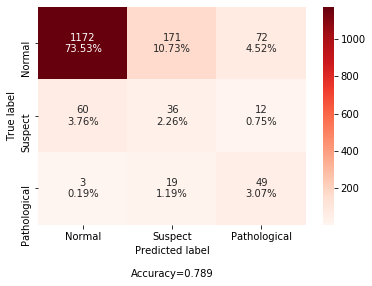

In [72]:
qda_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(qda_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

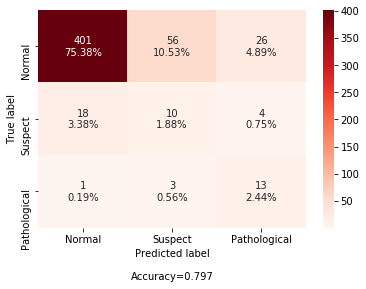

In [73]:
qda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(qda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [74]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.830     0.955     0.888       420
           2      0.312     0.145     0.198        69
           3      0.765     0.302     0.433        43

    accuracy                          0.797       532
   macro avg      0.636     0.467     0.507       532
weighted avg      0.758     0.797     0.762       532



#### Over-sampling

In [75]:
%%time
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train_os, y_train_os)
y_test_pred = qda_model.predict(X_test)

Wall time: 26.1 ms


C:\Users\serda\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


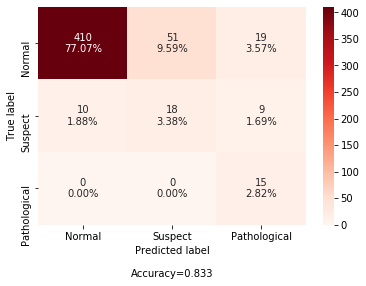

In [76]:
os_qda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(os_qda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [77]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.854     0.976     0.911       420
           2      0.486     0.261     0.340        69
           3      1.000     0.349     0.517        43

    accuracy                          0.833       532
   macro avg      0.780     0.529     0.589       532
weighted avg      0.818     0.833     0.805       532



#### Under-sampling

In [78]:
%%time
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train_us, y_train_us)
y_test_pred = qda_model.predict(X_test)

Wall time: 16 ms


C:\Users\serda\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


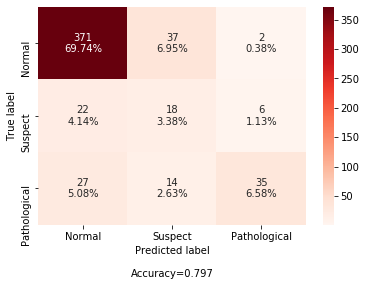

In [79]:
us_qda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(us_qda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [80]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.905     0.883     0.894       420
           2      0.391     0.261     0.313        69
           3      0.461     0.814     0.588        43

    accuracy                          0.797       532
   macro avg      0.586     0.653     0.598       532
weighted avg      0.802     0.797     0.794       532



**RESULTS FOR SAMPLING ON QDA:** Imbalanced data gives the best performance in QDA.

#### Normalization on Imbalanced Data

In [81]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm_imb = norm.transform(X_train)

# transform testing dataabs
X_test_norm_imb = norm.transform(X_test)

In [82]:
%%time
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train_norm_imb, y_train)
y_test_pred = qda_model.predict(X_test_norm_imb)

Wall time: 8 ms


C:\Users\serda\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


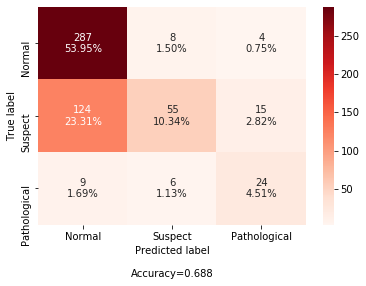

In [83]:
norm_us_qda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(norm_us_qda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [84]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.960     0.683     0.798       420
           2      0.284     0.797     0.418        69
           3      0.615     0.558     0.585        43

    accuracy                          0.688       532
   macro avg      0.620     0.680     0.601       532
weighted avg      0.844     0.688     0.732       532



#### Standardization on Imbalanced Data

In [85]:
# copy of datasets
X_train_stand_imb = X_train.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = dataset.drop(columns=['b','DS', 'NSP', 'AC', 'FM', 'UC', 'DL', 'DP', 'DR'])

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand_imb[[i]])
    
    # transform the training data column
    X_train_stand_imb[i] = scale.transform(X_train_stand_imb[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [86]:
%%time
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train_stand_imb, y_train)
y_test_pred = qda_model.predict(X_test_stand)

Wall time: 32 ms


C:\Users\serda\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


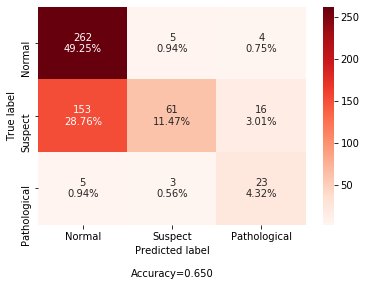

In [87]:
stand_us_qda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(stand_us_qda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [88]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.967     0.624     0.758       420
           2      0.265     0.884     0.408        69
           3      0.742     0.535     0.622        43

    accuracy                          0.650       532
   macro avg      0.658     0.681     0.596       532
weighted avg      0.858     0.650     0.702       532



**COMMENTS ON FEATURE SCALING** Standardization is better but again the best one unscaled, imbalanced one. Let's try to tune the parameters.

### Tuning for QDA

In [89]:
%%time
#Parameter tuning with GridSearchCV 
#######################
### QDA
#######################

estimator = QuadraticDiscriminantAnalysis()
parameters = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# with GridSearch
grid_search_qda = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv
)

qda_model2 = grid_search_qda.fit(X_train, y_train)
y_train_pred = qda_model2.predict(X_train)
y_test_pred = qda_model2.predict(X_test)

Wall time: 4.39 s


C:\Users\serda\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


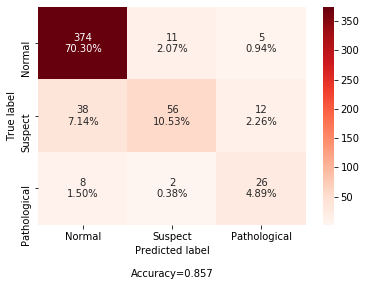

In [90]:
tune_norm_us_qda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_norm_us_qda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [91]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.959     0.890     0.923       420
           2      0.528     0.812     0.640        69
           3      0.722     0.605     0.658        43

    accuracy                          0.857       532
   macro avg      0.736     0.769     0.741       532
weighted avg      0.884     0.857     0.865       532



**RESULTS FOR QDA:** After parameter tuning we can predict more normal and suspect cases correctly but overall first QDA model (unscaled, imbalanced, without tuning) was the best.

## Naive Bayes

In [92]:
%%time
# training the model on training set 
nb = GaussianNB() 
nb_model = nb.fit(X_train, y_train) 
y_train_pred = nb_model.predict(X_train)

# making predictions on the testing set 
y_test_pred = nb_model.predict(X_test) 

Wall time: 35.9 ms


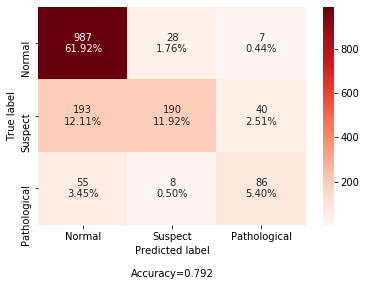

In [93]:
nb_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(nb_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

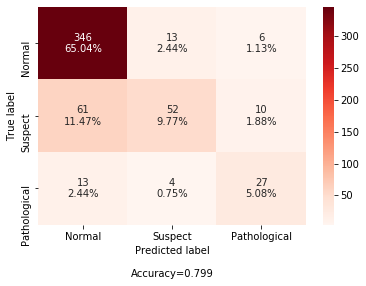

In [94]:
nb_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(nb_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [95]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.948     0.824     0.882       420
           2      0.423     0.754     0.542        69
           3      0.614     0.628     0.621        43

    accuracy                          0.799       532
   macro avg      0.661     0.735     0.681       532
weighted avg      0.853     0.799     0.816       532



#### Over-sampling

In [96]:
%%time
# training the model on training set 
nb = GaussianNB() 
nb_model = nb.fit(X_train_os, y_train_os) 

# making predictions on the testing set 
y_test_pred = nb_model.predict(X_test) 

Wall time: 16 ms


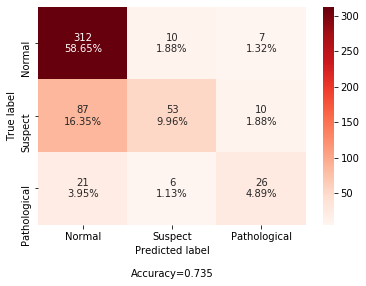

In [97]:
os_nb_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(os_nb_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [98]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.948     0.743     0.833       420
           2      0.353     0.768     0.484        69
           3      0.491     0.605     0.542        43

    accuracy                          0.735       532
   macro avg      0.597     0.705     0.620       532
weighted avg      0.834     0.735     0.764       532



#### Under-sampling

In [99]:
%%time
# training the model on training set 
nb = GaussianNB() 
nb_model = nb.fit(X_train_us, y_train_us) 

# making predictions on the testing set 
y_test_pred = nb_model.predict(X_test) 

Wall time: 16 ms


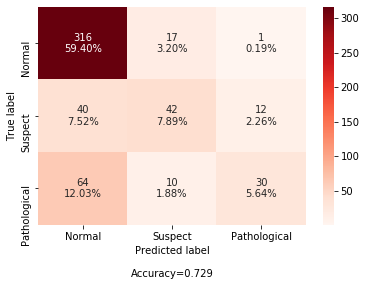

In [100]:
us_nb_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(us_nb_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [101]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.946     0.752     0.838       420
           2      0.447     0.609     0.515        69
           3      0.288     0.698     0.408        43

    accuracy                          0.729       532
   macro avg      0.560     0.686     0.587       532
weighted avg      0.828     0.729     0.762       532



**RESULTS FOR SAMPLING ON NAIVE BAYES:** SMOTE (Over-sampling) method work well for Suspect and Pathological cases but overall SMOTE (Over-sampling) and NearMiss (Under-sampling) do not give any better results.

### Tuning for Naive Bayes

In [102]:
%%time
#Parameter tuning with GridSearchCV 

##########################
### QGaussian Naive Bayes
##########################
estimator = GaussianNB()
parameters = {
    'var_smoothing': (0,1e-9,1e-7, 1e-5), 
                   }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# with GridSearch
grid_search_nb = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv
)

nb_model2 = grid_search_nb.fit(X_train, y_train)
y_train_pred = nb_model2.predict(X_train)
y_test_pred = nb_model2.predict(X_test)

Wall time: 996 ms


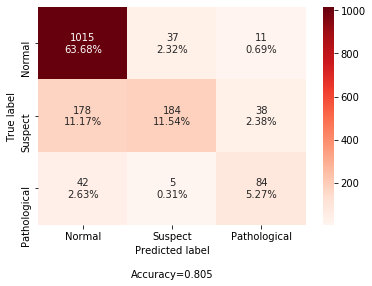

In [103]:
tune_nb_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_nb_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

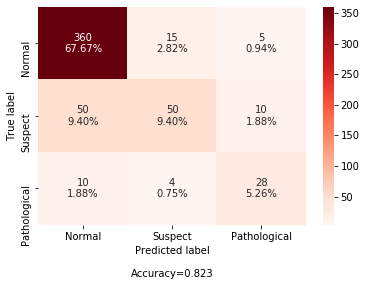

In [104]:
tune_nb_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_nb_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [105]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.947     0.857     0.900       420
           2      0.455     0.725     0.559        69
           3      0.667     0.651     0.659        43

    accuracy                          0.823       532
   macro avg      0.690     0.744     0.706       532
weighted avg      0.861     0.823     0.836       532



**RESULTS FOR NAIVE BAYES:** Overall, Over-sampling (SMOTE) and Under-sampling (NearMiss) didn't get any better results, despite SMOTE model have more correctly predicted cases for minority classes. After some tuning on Naive Bayes model, small improvement happened on that.

## SVM Linear

SVM tries to maximize the distance between the separating plane and the support vectors. If one feature (i.e. one dimension in this space) has very large values, it will dominate the other features when calculating the distance. If you rescale all features (e.g. to [0, 1]), they all have the same influence on the distance metric.

**`Source:`** Why scaling is important for the linear SVM classification (2013). Why scaling is important for the linear SVM classification? [online] Cross Validated. Available at: https://stats.stackexchange.com/questions/65094/why-scaling-is-important-for-the-linear-svm-classification [Accessed 5 Jan. 2021].

#### Standardization

In [106]:
%%time
svm_linear = SVC(kernel='linear')
svm_linear_model = svm_linear.fit(X_train_stand, y_train_os)
y_train_pred= svm_linear_model.predict(X_train_stand)

# making predictions on the testing set 
y_test_pred = svm_linear_model.predict(X_test_stand)

Wall time: 483 ms


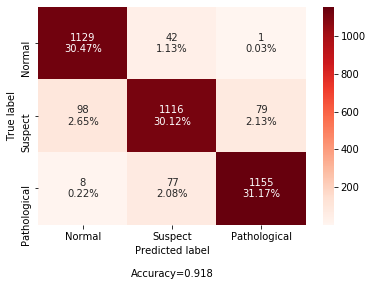

In [107]:
stand_svml_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(stand_svml_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

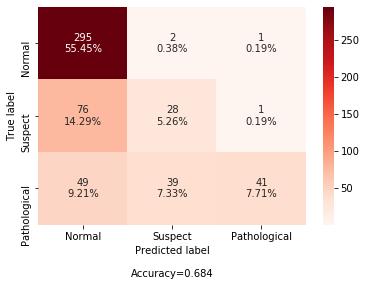

In [108]:
stand_svml_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(stand_svml_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [109]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.990     0.702     0.822       420
           2      0.267     0.406     0.322        69
           3      0.318     0.953     0.477        43

    accuracy                          0.684       532
   macro avg      0.525     0.687     0.540       532
weighted avg      0.842     0.684     0.729       532



#### Normalization

In [110]:
%%time
svm_linear = SVC(kernel='linear')
svm_linear_model = svm_linear.fit(X_train_norm, y_train_os)
y_train_pred= svm_linear_model.predict(X_train_norm)

# making predictions on the testing set 
y_test_pred = svm_linear_model.predict(X_test_norm)

Wall time: 773 ms


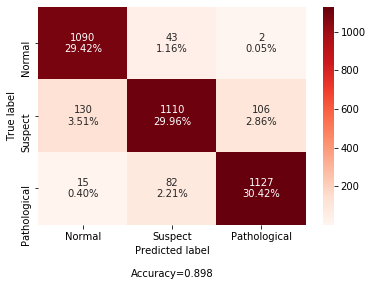

In [111]:
norm_svml_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(norm_svml_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

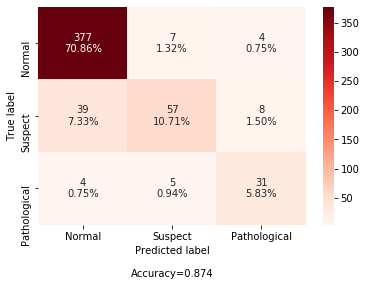

In [112]:
norm_svml_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(norm_svml_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [113]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.972     0.898     0.933       420
           2      0.548     0.826     0.659        69
           3      0.775     0.721     0.747        43

    accuracy                          0.874       532
   macro avg      0.765     0.815     0.780       532
weighted avg      0.901     0.874     0.883       532



**COMMENTS ON SCALING:** Standardization gives the best result on SVM Linear Kernel.

### Tuning for SVM Linear

In [114]:
%%time
#applying Gridsearchcv to find the best model
parameters = [{'C': [1,10,100], 'kernel': ['linear']}]
estimator= svm_linear

# with GridSearch
grid_search_svm = GridSearchCV(
    estimator = estimator,
    param_grid = parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10
)

svm_linear_model2 = grid_search_svm.fit(X_train_stand, y_train_os)
y_train_pred= svm_linear_model2.predict(X_train_stand)

# making predictions on the testing set 
y_test_pred = svm_linear_model2.predict(X_test_stand)

Wall time: 15.8 s


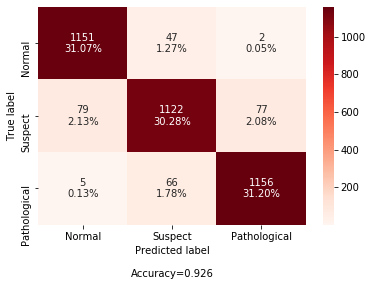

In [115]:
tune_stand_svml_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_stand_svml_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

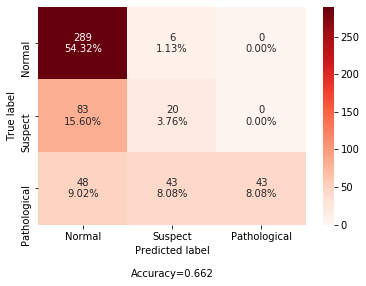

In [116]:
tune_stand_svml_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_stand_svml_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [117]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.980     0.688     0.808       420
           2      0.194     0.290     0.233        69
           3      0.321     1.000     0.486        43

    accuracy                          0.662       532
   macro avg      0.498     0.659     0.509       532
weighted avg      0.825     0.662     0.708       532



**RESULTS FOR SVM LINEAR:** Overall, standardization on Over-sampled (SMOTE) data with SVM Linear method gives the best results and after tuning model is going better.

## SVM Radial- Gaussian Kernel

In [118]:
%%time
svm_radial = SVC(kernel='rbf', probability=True)
svm_radial_model = svm_radial.fit(X_train, y_train)
y_train_pred= svm_radial_model.predict(X_train)

# making predictions on the testing set 
y_test_pred = svm_radial_model.predict(X_test)

Wall time: 1.27 s


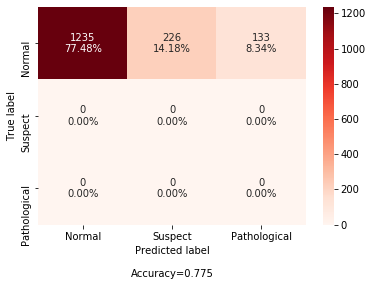

In [119]:
svmr_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(svmr_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

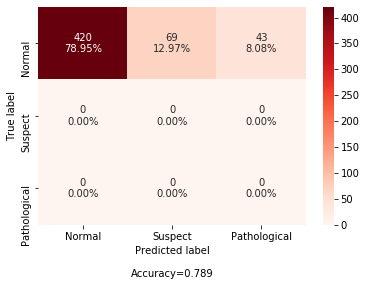

In [120]:
svmr_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(svmr_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [121]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.789     1.000     0.882       420
           2      0.000     0.000     0.000        69
           3      0.000     0.000     0.000        43

    accuracy                          0.789       532
   macro avg      0.263     0.333     0.294       532
weighted avg      0.623     0.789     0.697       532



C:\Users\serda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\serda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\serda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**COMMENT** As can be seen above, SVM Radial cannot predict the minority classes on imbalanced dataset. Let's see what will happen on balanced dataset.

#### Over-sampling

In [122]:
%%time
svm_radial = SVC(kernel='rbf', probability=True)
svm_radial_model = svm_radial.fit(X_train_os, y_train_os)
y_train_pred= svm_radial_model.predict(X_train_os)

# making predictions on the testing set 
y_test_pred = svm_radial_model.predict(X_test)

Wall time: 12.1 s


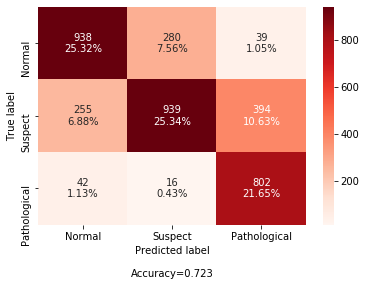

In [123]:
os_svmr_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(os_svmr_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

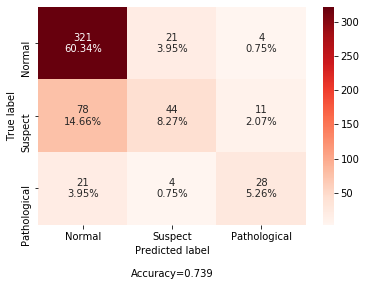

In [124]:
os_svmr_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(os_svmr_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [125]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.928     0.764     0.838       420
           2      0.331     0.638     0.436        69
           3      0.528     0.651     0.583        43

    accuracy                          0.739       532
   macro avg      0.596     0.684     0.619       532
weighted avg      0.818     0.739     0.765       532



#### Under-sampling

In [126]:
%%time
svm_radial = SVC(kernel='rbf', probability=True)
svm_radial_model = svm_radial.fit(X_train_us, y_train_us)
y_train_pred= svm_radial_model.predict(X_train_us)

# making predictions on the testing set 
y_test_pred = svm_radial_model.predict(X_test)

Wall time: 244 ms


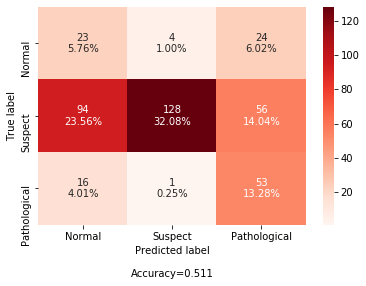

In [127]:
us_svmr_cm_tr = confusion_matrix(y_train_pred, y_train_us)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(us_svmr_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

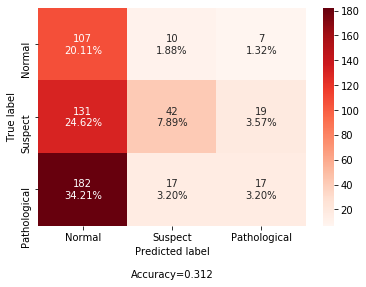

In [128]:
us_svmr_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(us_svmr_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [129]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.863     0.255     0.393       420
           2      0.219     0.609     0.322        69
           3      0.079     0.395     0.131        43

    accuracy                          0.312       532
   macro avg      0.387     0.420     0.282       532
weighted avg      0.716     0.312     0.363       532



**RESULTS FOR SAMPLING ON SVM RADIAL:** SMOTE (Over-sampling) method work well with SVM Radial kernel. The model is not so good but can be imroved with data scaling.

#### Standardization

In [130]:
%%time
svm_radial = SVC(kernel='rbf', probability=True)
svm_radial_model = svm_radial.fit(X_train_stand, y_train_os)
y_train_pred= svm_radial_model.predict(X_train_stand)

# making predictions on the testing set 
y_test_pred = svm_radial_model.predict(X_test_stand)

Wall time: 4.05 s


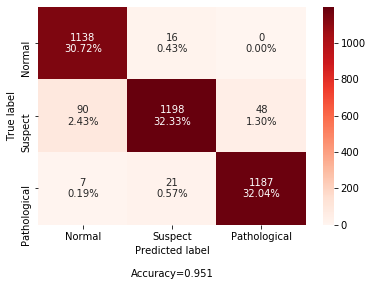

In [131]:
stand_os_svmr_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(stand_os_svmr_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

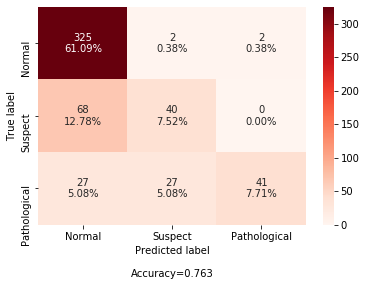

In [132]:
stand_os_svmr_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(stand_os_svmr_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [133]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.988     0.774     0.868       420
           2      0.370     0.580     0.452        69
           3      0.432     0.953     0.594        43

    accuracy                          0.763       532
   macro avg      0.597     0.769     0.638       532
weighted avg      0.863     0.763     0.792       532



#### Normalization

In [134]:
%%time
svm_radial = SVC(kernel='rbf', probability=True)
svm_radial_model = svm_radial.fit(X_train_norm, y_train_os)
y_train_pred= svm_radial_model.predict(X_train_norm)

# making predictions on the testing set 
y_test_pred = svm_radial_model.predict(X_test_norm)

Wall time: 3.07 s


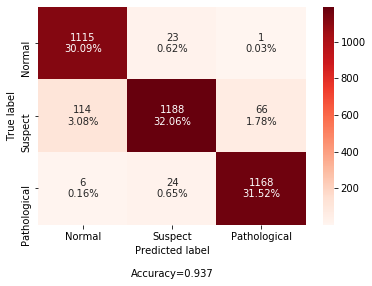

In [135]:
norm_os_svmr_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(norm_os_svmr_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

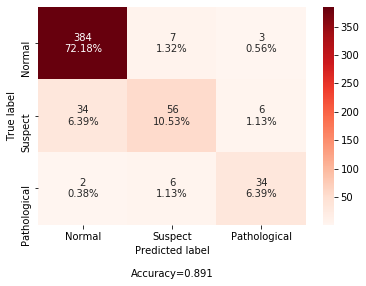

In [136]:
norm_os_svmr_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(norm_os_svmr_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [137]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.975     0.914     0.943       420
           2      0.583     0.812     0.679        69
           3      0.810     0.791     0.800        43

    accuracy                          0.891       532
   macro avg      0.789     0.839     0.807       532
weighted avg      0.911     0.891     0.898       532



**COMMENTS ON SCALING:** Standardization gives the best result on SVM Radial Kernel and model improvements are good. Briefly, we have decided to tune SVM on standardized and over-sampled data so far.

### Tuning for SVM Radial

In [138]:
%%time
# we can use a grid search cross-validation to explore combinations of parameters.
param_grid  = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}

# with GridSearch
grid_search_svm = GridSearchCV(
    SVC(),param_grid,refit=True,verbose=2
)

svm_radial_model2 = grid_search_svm.fit(X_train_stand, y_train_os)
y_train_pred = svm_radial_model2.predict(X_train_stand)

# making predictions on the testing set 
y_test_pred = svm_radial_model2.predict(X_test_stand)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.5s
[CV] END ......................C=0.1, gamma=0.01

In [139]:
print(grid_search_svm.best_estimator_)

SVC(C=100, gamma=0.1)


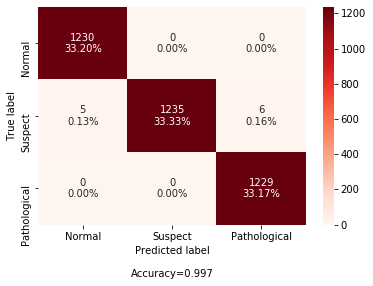

In [140]:
tune_stand_svmr_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_stand_svmr_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

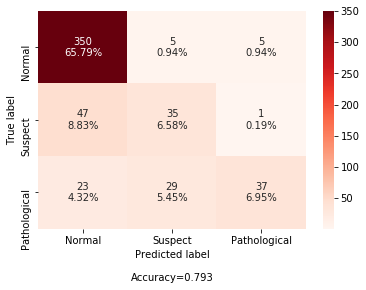

In [141]:
tune_stand_svmr_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_stand_svmr_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [142]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.972     0.833     0.897       420
           2      0.422     0.507     0.461        69
           3      0.416     0.860     0.561        43

    accuracy                          0.793       532
   macro avg      0.603     0.734     0.640       532
weighted avg      0.856     0.793     0.814       532



**RESULTS FOR SVM** Based on the results, we can say that the best SVM kernel is Radial. Overall, standardization on Over-sampled (SMOTE) data with SVM kernels gives the best results and after tuning models are going better.

## Tree

In [143]:
%%time
dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train,y_train)
y_train_pred= dt_model.predict(X_train)

#Predict the response for test dataset
y_test_pred = dt_model.predict(X_test)

Wall time: 79.7 ms


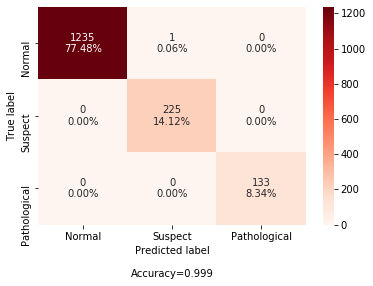

In [144]:
dt_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(dt_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

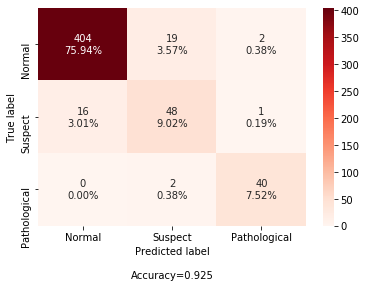

In [145]:
dt_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(dt_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [146]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.951     0.962     0.956       420
           2      0.738     0.696     0.716        69
           3      0.952     0.930     0.941        43

    accuracy                          0.925       532
   macro avg      0.880     0.863     0.871       532
weighted avg      0.923     0.925     0.924       532



#### Over-sampling

In [147]:
%%time
dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train_os,y_train_os)
y_train_pred= dt_model.predict(X_train_os)

#Predict the response for test dataset
y_test_pred = dt_model.predict(X_test)

Wall time: 88 ms


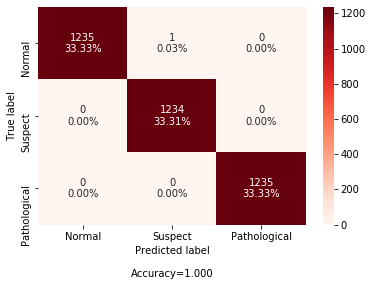

In [148]:
os_dt_cm_tr = confusion_matrix(y_train_pred, y_train_os)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(os_dt_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

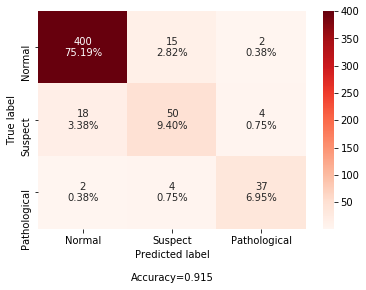

In [149]:
os_dt_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(os_dt_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [150]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.959     0.952     0.956       420
           2      0.694     0.725     0.709        69
           3      0.860     0.860     0.860        43

    accuracy                          0.915       532
   macro avg      0.838     0.846     0.842       532
weighted avg      0.917     0.915     0.916       532



#### Under-sampling

In [151]:
%%time
dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train_us,y_train_us)
y_train_pred= dt_model.predict(X_train_us)

#Predict the response for test dataset
y_test_pred = dt_model.predict(X_test)

Wall time: 24 ms


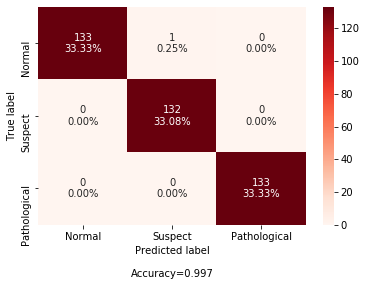

In [152]:
us_dt_cm_tr = confusion_matrix(y_train_pred, y_train_us)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(us_dt_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

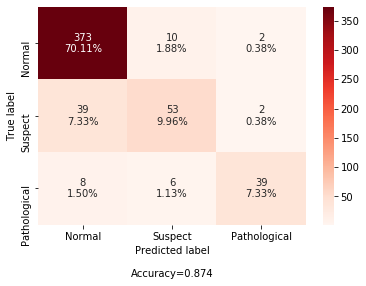

In [153]:
us_dt_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(us_dt_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [154]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.969     0.888     0.927       420
           2      0.564     0.768     0.650        69
           3      0.736     0.907     0.812        43

    accuracy                          0.874       532
   macro avg      0.756     0.854     0.797       532
weighted avg      0.897     0.874     0.882       532



**COMMENTS ON SAMPLING AND TREES** As can be seen above, sampling methods are not good for trees. Also, trees are not based on the distances, that's why data scaling haven't used.

### Tuning for Tree

In [155]:
%%time
parameters = {"criterion": ['gini', 'entropy'],
            "max_depth": range(1,10),
            "min_samples_split": range(1,10),
            "min_samples_leaf": range(1,5)}

grid_search_tree = GridSearchCV(dt, 
                        param_grid=parameters,
                        cv=10,
                        verbose=1,
                        n_jobs=-1)

dt_model2 = grid_search_tree.fit(X_train, y_train)

y_train_pred = dt_model2.predict(X_train)
y_test_pred = dt_model2.predict(X_test)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits
Wall time: 19.3 s


C:\Users\serda\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.82680818 0.82680818 0.82680818 0.82680818 0.82680818
 0.82680818 0.82680818 0.82680818        nan 0.82680818 0.82680818
 0.82680818 0.82680818 0.82680818 0.82680818 0.82680818 0.82680818
        nan 0.82680818 0.82680818 0.82680818 0.82680818 0.82680818
 0.82680818 0.82680818 0.82680818        nan 0.82680818 0.82680818
 0.82680818 0.82680818 0.82680818 0.82680818 0.82680818 0.82680818
        nan 0.88514151 0.88514151 0.88514151 0.88514151 0.88514151
 0.88514151 0.88514151 0.88514151        nan 0.88514151 0.88514151
 0.88514151 0.88514151 0.88514151 0.88514151 0.88514151 0.88514151
        nan 0.88514151 0.88514151 0.88514151 0.88514151 0.88514151
 0.88514151 0.88514151 0.88514151        nan 0.88514151 0.88514151
 0.88514151 0.88514151 0.88514151 0.88514151 0.88514151 0.88514151
        nan 0.90209513 0.90209513 0.90209513 0.902095

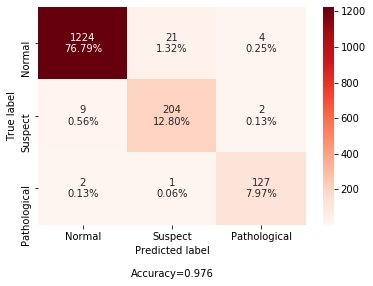

In [156]:
tune_dt_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_dt_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

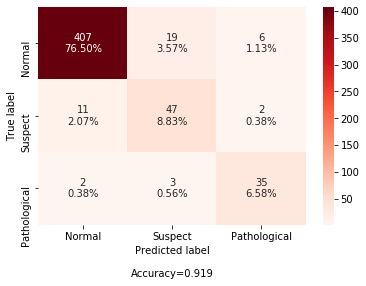

In [157]:
tune_dt_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_dt_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [158]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.942     0.969     0.955       420
           2      0.783     0.681     0.729        69
           3      0.875     0.814     0.843        43

    accuracy                          0.919       532
   macro avg      0.867     0.821     0.842       532
weighted avg      0.916     0.919     0.917       532



**RESULTS FOR TREE** Based on the results, we can say that the best tree model was imbalanced, unscaled and untuned one which is first model.

## Random Forest

In [159]:
%%time
rf = RandomForestClassifier(n_estimators=20, random_state=0)
model_rf = rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)

Wall time: 221 ms


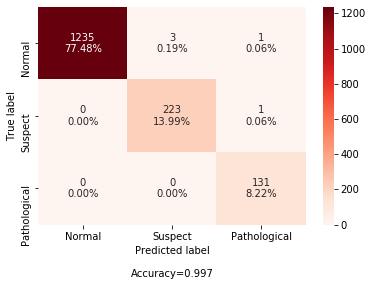

In [160]:
rf_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(rf_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

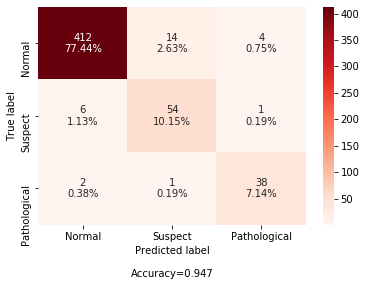

In [161]:
rf_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(rf_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [162]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.958     0.981     0.969       420
           2      0.885     0.783     0.831        69
           3      0.927     0.884     0.905        43

    accuracy                          0.947       532
   macro avg      0.923     0.882     0.902       532
weighted avg      0.946     0.947     0.946       532



#### Over-sampling

In [163]:
%%time
rf = RandomForestClassifier(n_estimators=20, random_state=0)
model_rf = rf.fit(X_train_os, y_train_os)
y_test_pred = model_rf.predict(X_test)

Wall time: 283 ms


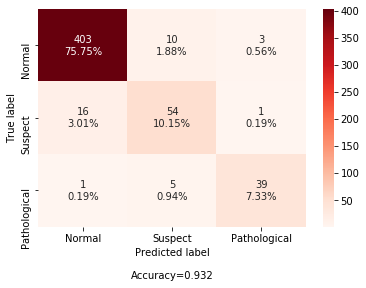

In [164]:
os_rf_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(os_rf_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [165]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.969     0.960     0.964       420
           2      0.761     0.783     0.771        69
           3      0.867     0.907     0.886        43

    accuracy                          0.932       532
   macro avg      0.865     0.883     0.874       532
weighted avg      0.933     0.932     0.933       532



#### Under-sampling

In [166]:
%%time
rf = RandomForestClassifier(n_estimators=20, random_state=0)
model_rf = rf.fit(X_train_us, y_train_us)
y_test_pred = model_rf.predict(X_test)

Wall time: 135 ms


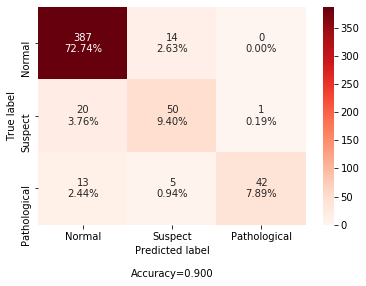

In [167]:
us_rf_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(us_rf_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [168]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.965     0.921     0.943       420
           2      0.704     0.725     0.714        69
           3      0.700     0.977     0.816        43

    accuracy                          0.900       532
   macro avg      0.790     0.874     0.824       532
weighted avg      0.910     0.900     0.903       532



**RESULTS FOR SAMPLING ON RANDOM FOREST:** SMOTE (Over-sampling) method is slightly better in prediction of pathological cases but oeverall imbalanced data is the best.

### Tuning for Random Forest

In [169]:
%%time
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

pprint(random_grid)

{'max_depth': [1, 23, 45],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [5, 10],
 'n_estimators': [20, 65, 110, 155, 200]}
Wall time: 8.01 ms


In [170]:
%%time
# Random search of parameters, using 30 fold cross validation, 
# search across 300 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, n_iter = 10, cv = cv, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_model2 = rf_random.fit(X_train, y_train)
y_test_pred = rf_model2.best_estimator_.predict(X_test)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
Wall time: 21.1 s


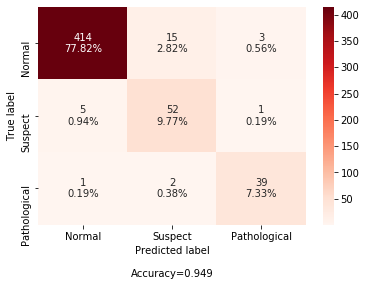

In [171]:
tune_os_rf_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(tune_os_rf_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [172]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.958     0.986     0.972       420
           2      0.897     0.754     0.819        69
           3      0.929     0.907     0.918        43

    accuracy                          0.949       532
   macro avg      0.928     0.882     0.903       532
weighted avg      0.948     0.949     0.948       532



**RESULTS FOR RANDOM FOREST:** In conclusion, Random Forest works great and tuning parameter is good idea.

## Model Ensembling

### Voting Classifier (Soft)

In [173]:
%%time
# Voting Classifier with soft voting
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
clf4 = KNeighborsClassifier()
clf5= LinearDiscriminantAnalysis()
clf6= XGBClassifier()

vot_soft = VotingClassifier(estimators = [('DTree', clf1), ('rf', clf2), ('gnb', clf3), ('knn', clf4), ('lda', clf5), ('xgb', clf6)], voting ='soft') 
for clf, label in zip([clf1, clf2, clf3,clf4,clf5,clf6, vot_soft], ['Decision Tree', 'Random Forest', 'naive Bayes', 'Knn', 'LDA', 'Xgboost', 'Ensemble']):
        scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

eclf_model = vot_soft.fit(X_train, y_train)
y_train_pred= eclf_model.predict(X_train)
y_test_pred= eclf_model.predict(X_test)

Accuracy: 0.91 (+/- 0.02) [Decision Tree]
Accuracy: 0.94 (+/- 0.02) [Random Forest]
Accuracy: 0.79 (+/- 0.04) [naive Bayes]
Accuracy: 0.86 (+/- 0.02) [Knn]
Accuracy: 0.88 (+/- 0.03) [LDA]
Accuracy: 0.95 (+/- 0.02) [Xgboost]
Accuracy: 0.93 (+/- 0.02) [Ensemble]
Wall time: 24 s


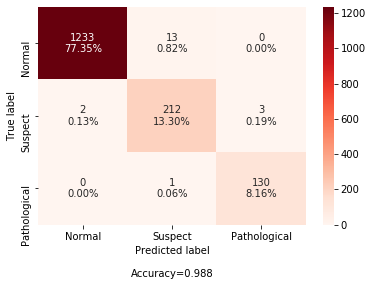

In [174]:
eclf_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(eclf_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

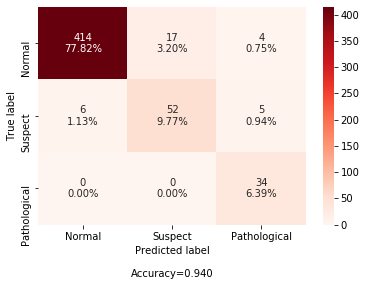

In [175]:
eclf_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(eclf_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [176]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.952     0.986     0.968       420
           2      0.825     0.754     0.788        69
           3      1.000     0.791     0.883        43

    accuracy                          0.940       532
   macro avg      0.926     0.843     0.880       532
weighted avg      0.939     0.940     0.938       532



## XGBOOST

In [177]:
%%time
XGBoost = XGBClassifier()
xgb_model = XGBoost.fit(X_train, y_train)
y_train_pred= xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

Wall time: 729 ms


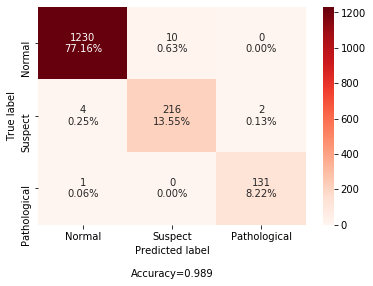

In [178]:
xgb_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(xgb_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

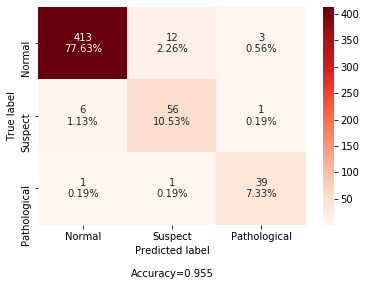

In [179]:
xgb_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(xgb_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [180]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.965     0.983     0.974       420
           2      0.889     0.812     0.848        69
           3      0.951     0.907     0.929        43

    accuracy                          0.955       532
   macro avg      0.935     0.901     0.917       532
weighted avg      0.954     0.955     0.954       532



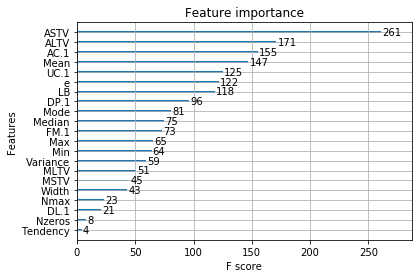

In [181]:
xgb.plot_importance(XGBoost)
plt.rcParams['figure.figsize'] = (16,8)
plt.show()

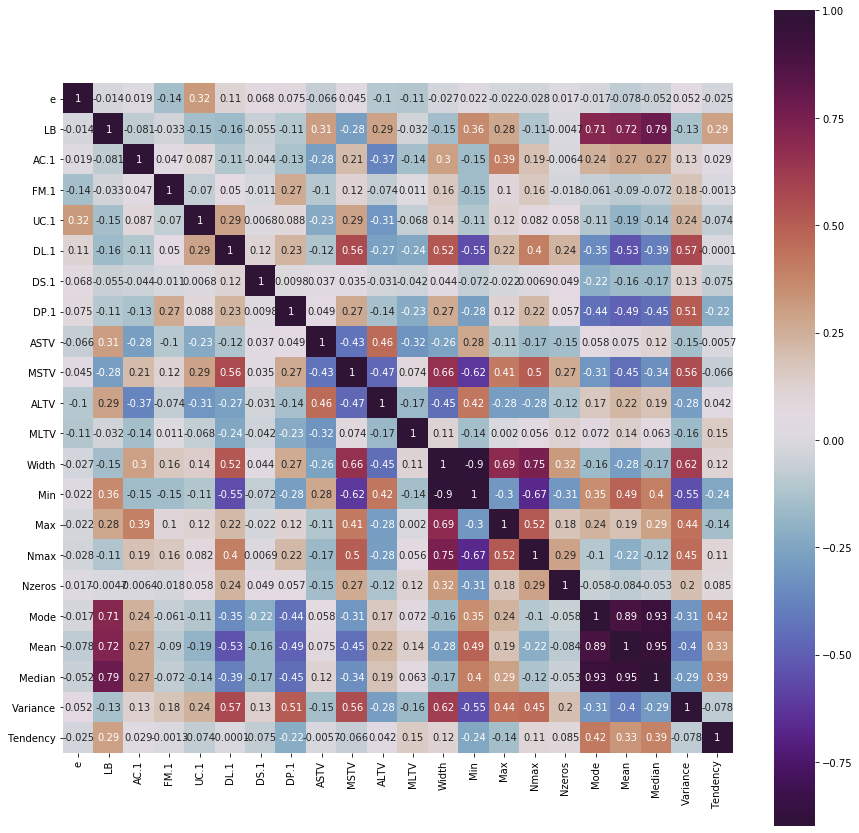

In [182]:
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(),square=True,annot=True,cmap= 'twilight_shifted')

### Tuning for XGboost

In [183]:
%%time
acctrain= []
acctest= []

for i in range(100,200):
    XGBoost = XGBClassifier(n_estimators=i+1, max_depth = 3) #change max_depth because 1 is very poor
    xgb_model2 = XGBoost.fit(X_train, y_train)
    y_train_pred = xgb_model2.predict(X_train)
    y_test_pred= xgb_model2.predict(X_test)
    acctrain.append(accuracy_score(y_train, y_train_pred))
    acctest.append(accuracy_score(y_test, y_test_pred))
    
print(acctrain)
print(acctest)

[0.9893350062735258, 0.9893350062735258, 0.9893350062735258, 0.9893350062735258, 0.9887076537013801, 0.9887076537013801, 0.9887076537013801, 0.9893350062735258, 0.9893350062735258, 0.9893350062735258, 0.9899623588456713, 0.9893350062735258, 0.9893350062735258, 0.9899623588456713, 0.9918444165621079, 0.9918444165621079, 0.9918444165621079, 0.9918444165621079, 0.9918444165621079, 0.9918444165621079, 0.9918444165621079, 0.9918444165621079, 0.9918444165621079, 0.9918444165621079, 0.9918444165621079, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.993099121706399, 0.9937264742785445, 0.9937264742785445, 0.9937264742785445, 0.9937264742785445, 0.9943538268506901, 0.9956085319949812, 0.9956085319949812, 0.9949811794228356, 0.9956085319949812, 0.9956085319949812, 0.9956085319949812, 0.9956085319949812, 0.9962358845671268, 0.996235884

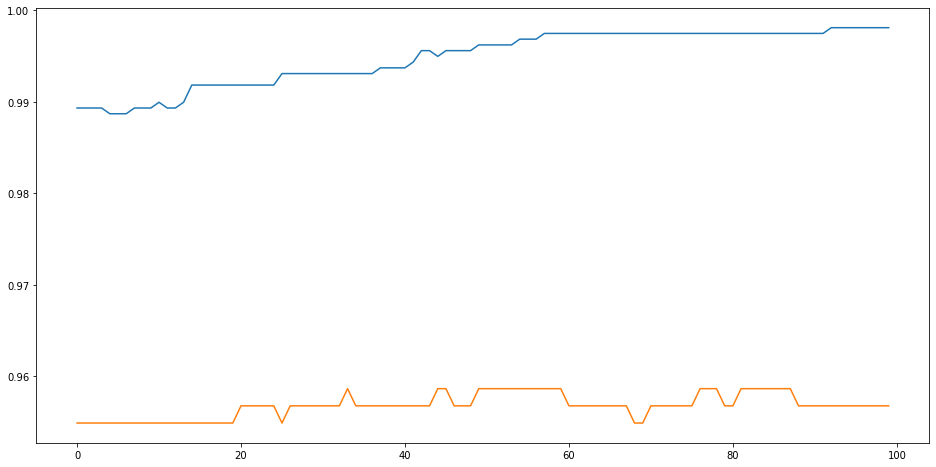

In [184]:
plt.plot(acctrain)
plt.plot(acctest)

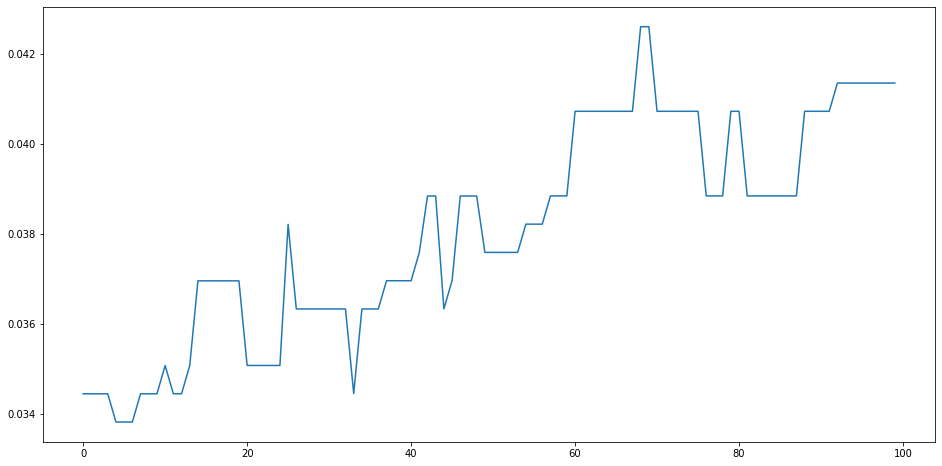

In [185]:
# difference between train and test set (how much larger accuracy in train set over the test set)
plt.plot([tr_a - te_a for tr_a, te_a in zip(acctrain, acctest)])

In [186]:
%%time
XGBoost = XGBClassifier(n_estimators=134, max_depth = 3)
xgb_model3 = XGBoost.fit(X_train, y_train)
y_train_pred= xgb_model3.predict(X_train)
y_test_pred = xgb_model3.predict(X_test)

Wall time: 1.47 s


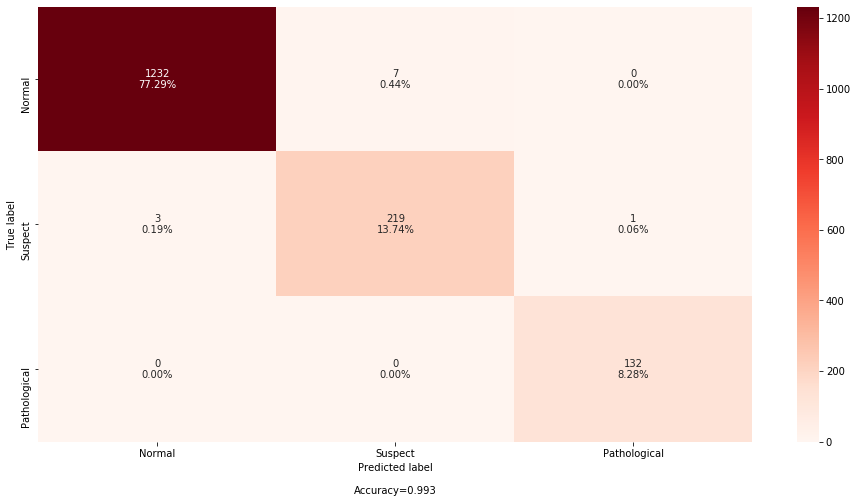

In [187]:
xgb_cm_tr = confusion_matrix(y_train_pred, y_train)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(xgb_cm_tr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [188]:
print(classification_report(y_train, y_train_pred, digits=3))

              precision    recall  f1-score   support

           1      0.994     0.998     0.996      1235
           2      0.982     0.969     0.976       226
           3      1.000     0.992     0.996       133

    accuracy                          0.993      1594
   macro avg      0.992     0.986     0.989      1594
weighted avg      0.993     0.993     0.993      1594



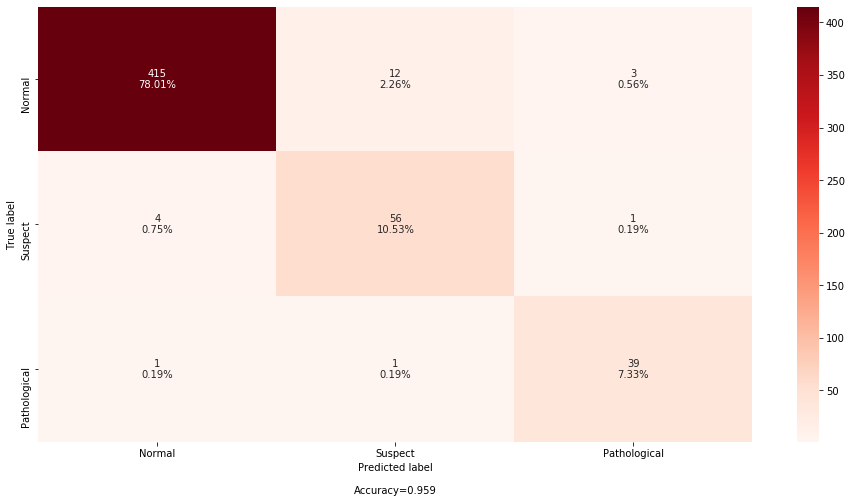

In [189]:
xgb_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['Normal', 'Suspect', 'Pathological']
make_confusion_matrix(xgb_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [190]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           1      0.965     0.988     0.976       420
           2      0.918     0.812     0.862        69
           3      0.951     0.907     0.929        43

    accuracy                          0.959       532
   macro avg      0.945     0.902     0.922       532
weighted avg      0.958     0.959     0.958       532



### SHAP

`WARNING` Before run the codes below please import shap module from the top.

In [191]:
#expl_xgb = shap.TreeExplainer(xgb_model3)
#shap_xgb = expl_xgb.shap_values(X_train)

In [192]:
#shap.summary_plot(shap_xgb, X_train, plot_type="bar")

In [193]:
# XGBoost Tree SHAP algorithm computes the SHAP values with respect to the margin, not the transformed probability.
#shap.initjs()
#shap.force_plot(expl_xgb.expected_value, shap_xgb[10,:], X_train.iloc[10,:], link='logit')